In [1]:
%load_ext autoreload
%autoreload 2
!pip install -r requirements.txt

## Multi-Armed bandits

- MDP with no state
- we want to minimize the total regret (how much reward you lost by not selecting optimal action up to time T)

### Regret

- **information state search**: exploration provides information which can increase expected reward in future 
- optimal solutions can be found by solving infinte-state MDP over info states
- need heuristics to make things tractable

bandit strategies scale with how we handle uncertainty:

- no exploration, just greedily pull best values we have seen in past
- random exploration
- explore with preference towards uncertaint



In [57]:
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import matplotlib.pyplot as plt

n_arms = 8
probs = np.zeros(n_arms) + 0.5
probs[np.random.choice(range(4))] = 0.9
config = {"num_arms" : n_arms, "probs": probs}
env = Bandit(config)


button = widgets.ToggleButtons(
    options=list(range(n_arms)),
    description='Arm:',
)

def click(value):
    env.step(value)
    
    fig, axs = plt.subplots(1, 2)
    axs[0].bar(range(env.n_arms), env.cumulative_reward / (env.visits + 0.001))
    
    cumulative_r = np.cumsum(env.regret)
    steps = np.arange(len(cumulative_r))
    axs[1].plot(steps, cumulative_r, label="Your regret")
    axs[1].plot(steps, 0.6 * steps, label="Random")
    plt.legend()
    print(f"Total steps: {env.visits.sum()}")

interact(click, value=button)

interactive(children=(ToggleButtons(description='Arm:', options=(0, 1, 2, 3, 4, 5, 6, 7), value=0), Output()),…

<function __main__.click(value)>

/home/luke1/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


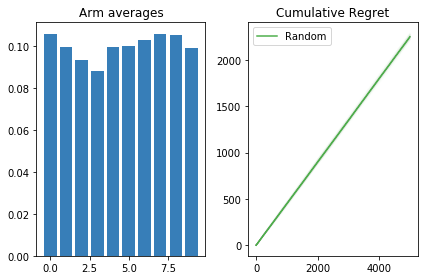

In [58]:
import numpy as np
from copy import deepcopy

from envs.bandit import Bandit
from utils import *

n_steps = 5000
n_trials = 50
n_arms = 10
config = {"num_arms" : n_arms, "probs": (1/n_arms) * np.arange(n_arms)}
env = Bandit(config)

def random_selection(env):
    return np.random.randint(env.n_arms)

random = run_simulation(random_selection, env, n_steps=n_steps, n_trials=n_trials)
plot_simulation([random], env)
plt.show()

     


### $\epsilon$-Greedy Algorithm

action value is just average of rewards we have seen over time

e-Greedy just selects the non-max at random sometimes


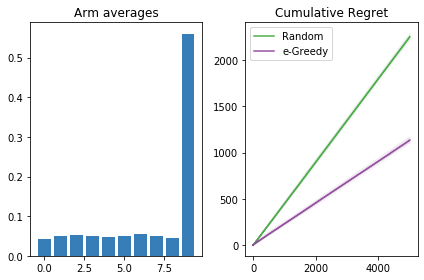

In [59]:
epsilon = 0.5
def e_greedy_selection(env):
    if np.random.rand() < epsilon:
        return np.random.randint(env.n_arms)
    else:
        return np.argmax(env.arm_avgs())
    
egreedy = run_simulation(e_greedy_selection, env, n_steps=n_steps, n_trials=n_trials)
plot_simulation([random, egreedy], env)
plt.show()


### UCB Algorithm

e-Greedy not awesome because a lot of the time we end up exploring bad actions that we sort of know will not yield anything great

The idea is to agument the value function with an upper bound on the reward value so that the true reward value is lower: $Q(a) \leq \hat{Q}_t(a) + \hat{U}_t(a)$.

Hoeffding's inequality can be used if we do not want to assign any prior to the distribution of rewards, works for any bounded distribution. 

$$P[\frac{1}{n} \sum_{i =1}^{n}(Z_i - E[Z_i]) \geq \delta\ ] \leq e^{- \frac{2n\delta^2}{(b - a)^2}}$$

So we view this average of the random variable $Z_i$ as the averaged reward of a particular action, $\hat{Q_t}(a) = \frac{1}{n} \sum_{t=0}^n R_i$. The inequality then gets written as (with $t = N_t(a)$, the number of times this action has been visited): 

$$P[Q_t - \hat{Q_t} \geq \delta ] \leq e^{-\frac{2N_t(a)\delta^2}{(b-a)^2}}$$

We see that then our upper bound on the true reward can be given by $\delta = \hat{U_t}(a)$. And if we make the simplifying assumption that the reward is bounded to be on the interval $(0, 1)$. We can then for any value of the probability of deviation, $p$, we can solve for what we expect the upper bound on that deviation to be:

$$
p \approx e^{-2N_t(a)U_t(a)^2} \\
U_t(a) = \sqrt{\frac{- \log p}{2 N_t (a)}}
$$

Most of the time in practice, we use a heuristic to drop this $p$ over time, typically $p=t^{-4}$.

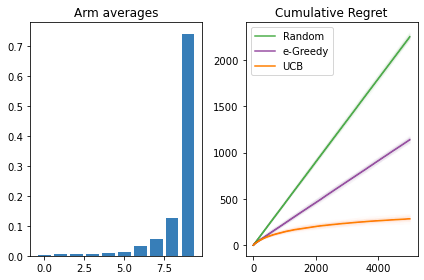

In [4]:
def ucb_selection(env):
    ucb = np.sqrt((2 * np.log(env.visits.sum())) / env.visits)
    mod_avgs = env.arm_avgs() + ucb
    return np.argmax(mod_avgs)

ucb = run_simulation(ucb_selection, env, n_steps=n_steps, n_trials=n_trials)
plot_simulation([random, egreedy, ucb], env)
plt.show()

## Contextual Bandits

The next class of environments we will look at are referred to as "Contexual" bandit problems. This refers to an observation we get to perform before choosing our action. The observation allows us to have "context" of the situation to use in choosing a useful action.

Examples of these types of problems are very common in recommender systems. We can think of a user having a context (or in a profile) that we can review before making a decision as to what ad we should serve or movie we can recommend.

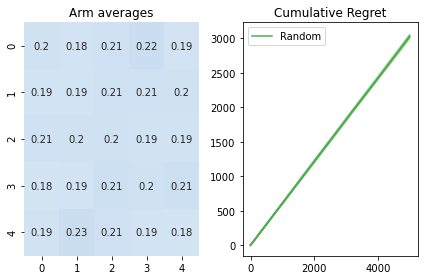

In [5]:
import numpy as np

from envs.context_bandit import *
from utils import *

n_steps = 5000
n_trials = 50
n_arms = 5
n_states = 5
# state_probs = np.array([[0.1, 0.9], [0.9, 0.1]])
state_probs = get_state_probs(n_states, n_arms)
config = {
    "num_arms" : n_arms,
    "num_states" : n_states,
    "state_probs": state_probs
}

env = ContextualBandit(config)
def random_selection(env):
    return np.random.randint(env.n_arms)

random = run_simulation(random_selection, env, n_steps=n_steps, n_trials=n_trials)
plot_contextual_simulation([random], env)
plt.show()

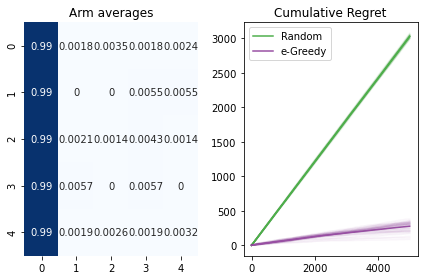

In [6]:
epsilon = 0.01
def e_greedy_selection(env):
    if np.random.rand() < epsilon:
        return np.random.randint(env.n_arms)
    else:
        return np.argmax(env.arm_avgs(env.state))
    
egreedy = run_simulation(e_greedy_selection, env, n_steps=n_steps, n_trials=n_trials)
plot_contextual_simulation([random, egreedy], env)
plt.show()

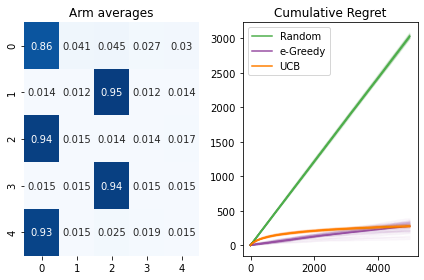

In [7]:
def ucb_selection(env):
    ucb = np.sqrt((2 * np.log(env.visits[env.state, :].sum())) / env.visits[env.state, :])
    mod_avgs = env.arm_avgs(env.state) + ucb
    return np.argmax(mod_avgs)

ucb = run_simulation(ucb_selection, env, n_steps=n_steps, n_trials=n_trials)
plot_contextual_simulation([random, egreedy, ucb], env)
plt.show()

# Modern Monte Carlo Tree Search

How can we efficiently search without relying on expert knowledge?

- **exploration**: learn values of actions we are uncertain about
- **exploitation**: focus search on promising parts of tree



## Markov Decision Processes (MDPs)

We have been building up the problem description in a more and more complex manner over the course of this presentation.

Our agents have only seen a state, took an action, and then recieved a reward for how they acted. There was no notion of time in any of these algorithms and so the agents actions had no effect on the future. Real decision making processes have some degree of effect on the payoff you get. We can model these systems with MDPs.

MDPs are a pretty general framework for dealing with decision making over some sort of horizon (possibly even infinite).



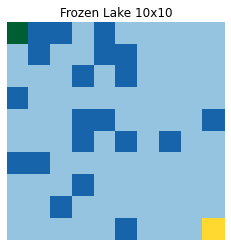

In [11]:
from envs.frozen_lake import FrozenLakeEnv
from value_iteration import *
from mcts import *

env = FrozenLakeEnv(10)
state = env.reset()
env.render()

## Value Functions

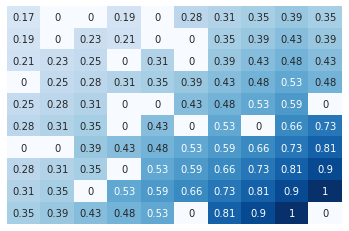

In [12]:
value_fcn = value_iteration(env, gamma=0.9)
plot_value_function(value_fcn, env)

In [13]:
mcts = MCTS(env)
env.get_action(mcts.next_move(state))

Move DOWN


'DOWN'

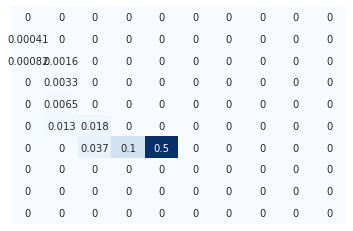

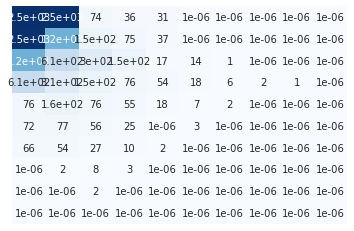

In [16]:
plot_value_function(mcts.value_fcn(), env)
plot_value_function(mcts.visitation_fcn(), env)

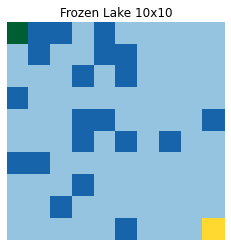

Move LEFT
Move LEFT
Move LEFT
Move LEFT
Move LEFT
Move LEFT
Move LEFT
Move LEFT
Move LEFT
Move LEFT
Move LEFT
Move LEFT
Move LEFT
Move LEFT
Move LEFT
Move LEFT
Move LEFT
Move DOWN
Move DOWN
Move LEFT
Move RIGHT
Move DOWN
Move DOWN
Move DOWN
Move RIGHT
Move DOWN
Move RIGHT
Move RIGHT
Move RIGHT
Move RIGHT
Move DOWN
Move DOWN
Move DOWN
Move RIGHT
Move UP
Move DOWN
Move RIGHT
Success! 38 moves


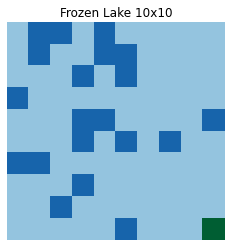

In [19]:
state = env.reset()
done = False

env.render()
steps = 0
while not done:
    mcts = MCTS(env)
    action = mcts.next_move(state)
    state, reward, done, _ = env.step(action)
    steps += 1

    # env.render()
    # plot_value_function(mcts.value_fcn(), env)

print(f"Success! {steps} moves")
env.render()